# Basic Model with Subsidy

Apart from fees earned through issue and redeem, this model considers a subsidy paid by the Polkadot Treasury. The model here is a copy of the `basic` model with the added subsidy. All else is equal.

#### Imports

In [1]:
# Packages
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Plot customization
sns.set_theme(style="ticks", color_codes=True)
sns.set_context("paper")
sns.set_style("whitegrid")
pd.options.display.float_format = "{:,.2f}".format

# PolkaBTC imports
from environment import Environment
from polkabtc import PolkaBTC
from agents import Agents

#### System Init

In [2]:
# init environment
env = Environment()

agents = Agents()
polkabtc = PolkaBTC()

# Init issued btc with 0 
btc_issued = 0

#### PolkaBTC Parameterization

In [3]:
# Set exchange rates
btc_in_usd = 58_360.17
dot_in_usd = 41.10
# feed in the current btc and dot prices
env.setCurrentExchangeRates(btc_in_usd, dot_in_usd)
# NOTE: the oracle in polkabtc needs to be manually updated as to simulate differences in the "true" exchange rate to the system exchange rate later on
polkabtc.oracle.setRates(env)

# Set transaction fees
polkadot_tx_fee = 452_088_000 # in Planck see https://github.com/interlay/btc-parachain/blob/master/crates/issue/src/default_weights.rs
sat_per_byte = 19 # bitcoin transaction fees per byte in Sat
# feed in transaction costs
env.setTransactionCosts(sat_per_byte, polkadot_tx_fee)


# set 0 griefing collateral and 0.5% issue fee
polkabtc.issue.setModel(
    griefing_collateral=0, 
    fee=0.005
)

# set the collateral thresholds
polkabtc.vault_registry.setThresholds(secure=1.5, auction=1.2, premium=1.3, liquidation=1.1)

# set distribution of issue fees among agents
polkabtc.fee_share.setIssue(
    vault=0.77, 
    relayer=0.03, 
    maintainer=0.2, 
    collator=0
)

# subsidy in dot
dot_subsidy = 850_000
polkabtc.subsidy.setShare(vault=0.9, relayer=0.0, maintainer=0.1, collator=0)

# Set average Issue request size
btc_per_transaction = 1

# Set total amount of BTC-backed assets issued per round
# 15.000 BTC = USD 875.402.550 (~8% of BTC locked on Ethereum on 8 April 2021)
new_btc_to_issue_per_round = 15000/12

# Set duration in rounds; "round" can be any time unit (day, week, month,...)
# here we assume 15.000 BTC being locked over a period of 12 months
rounds = 12

### Analysis

In [4]:
# init total fees pandas DataFrame
total_fees = agents.get_accumulated_fees_in_usd(env, btc_issued)

for i in range(rounds):
    btc_issued += new_btc_to_issue_per_round
    polkabtc.execute_issue(env, agents, new_btc_to_issue_per_round, btc_per_transaction)
    polkabtc.pay_subsidy(agents, dot_subsidy)

    # get all fees in usd as a list sorted by user, vault, relayer, maintainer, collator
    # the fees are based on the exchange rates set in `env`
    fees = agents.get_accumulated_fees_in_usd(env, polkabtc.total_polkaBTC)
    total_fees = total_fees.append(fees, ignore_index=True)

print("PolkaBTC issued [BTC]: {}".format(btc_issued))
print("PolkaBTC issued [USD]: {}". format(env.btcToUsd(btc_issued)))
print("Fees Vault [USD]: \n{}".format(total_fees[total_fees["agents"] == "vault"]))
print("Fees Relayer [USD]: \n{}".format(total_fees[total_fees["agents"] == "relayer"]))
#print("Fees Maintainer [USD]: \n{}".format(total_fees[total_fees["agents"] == "maintainer"]))
print("Fees Collator [USD]: \n{}".format(total_fees[total_fees["agents"] == "collator"]))


PolkaBTC issued [BTC]: 15000.0
PolkaBTC issued [USD]: 875402550.0
Fees Vault [USD]: 
    total_btc    locked_dot   locked_dot_usd agents   fees_abs_usd  \
1        0.00          0.00             0.00  vault           0.00   
6    1,250.00  2,662,416.51   109,425,318.75  vault  31,722,358.32   
11   2,500.00  5,324,833.03   218,850,637.50  vault  63,444,716.64   
16   3,750.00  7,987,249.54   328,275,956.25  vault  95,167,074.95   
21   5,000.00 10,649,666.06   437,701,275.00  vault 126,889,433.27   
26   6,250.00 13,312,082.57   547,126,593.75  vault 158,611,791.59   
31   7,500.00 15,974,499.09   656,551,912.50  vault 190,334,149.91   
36   8,750.00 18,636,915.60   765,977,231.25  vault 222,056,508.23   
41  10,000.00 21,299,332.12   875,402,550.00  vault 253,778,866.54   
46  11,250.00 23,961,748.63   984,827,868.75  vault 285,501,224.86   
51  12,500.00 26,624,165.15 1,094,253,187.50  vault 317,223,583.18   
56  13,750.00 29,286,581.66 1,203,678,506.25  vault 348,945,941.50   
61  1

### PolkaBTC Parameterization

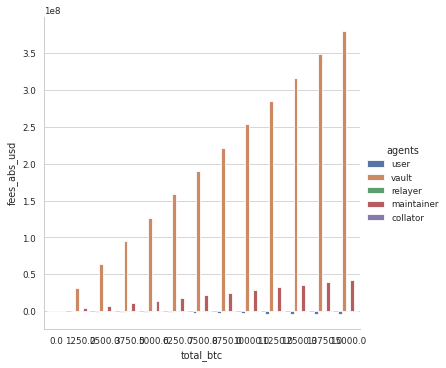

In [5]:
sns.catplot(kind="bar", x="total_btc", y="fees_abs_usd", hue="agents", data=total_fees)

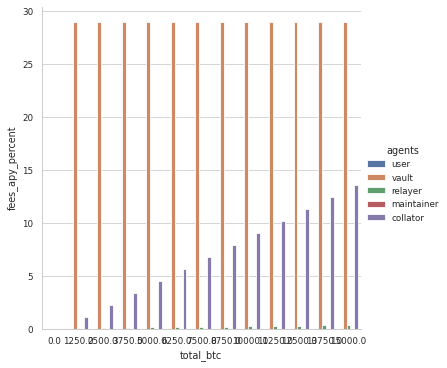

In [6]:
sns.catplot(kind="bar", x="total_btc", y="fees_apy_percent", hue="agents", data=total_fees)